In [1]:
!pip install -q flwr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 598.1/598.1 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.4/242.4 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.0/236.0 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 2.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-api-core 1.34.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<4.0.0dev,>=3.19.5, but you have protobuf 4.25.8 which is incompatible.
google-spark-connect 0.5.2 requires google-api-core>=2.19.1, but you have google-api-core 1.34.1 which is incompatible.
google-cloud-bigtable 2.30.0 requires google-api-core[grpc]<3.0.0,>=2.16.0, but you have google-api-core 1.34.1 which i

In [2]:
!pip install -U flwr

In [4]:
# --- Imports ---
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import gc
import flwr as fl
from flwr.client import NumPyClient
from flwr.common import Context
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg
from flwr.simulation import run_simulation


# --- Load and prepare data ---
data = np.load("/kaggle/input/daicwoz-balanced/dataset_balanced.npz")
test_ids = np.load("/kaggle/input/daicwoz-balanced/test_ids (1).npy")

X_audio_test = data["X_audio_test"]
X_text_test = data["X_text_test"]
y_test = data["y_test"]

X_audio_dev = data["X_audio_dev"]
X_text_dev = data["X_text_dev"]
y_dev = data["y_dev"]

X_audio_train = data["X_audio_train"]
X_text_train = data["X_text_train"]
y_train = data["y_train"]

y_train = y_train.reshape(-1, 1)
y_dev = y_dev.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# --- Parameters ---
NUM_CLIENTS = 10
input_shape_audio = (378, 60)
input_shape_text = (378, 9)

# --- Build model ---
def build_model():
    input_audio = layers.Input(shape=input_shape_audio, name='mfcc_input')
    x_audio = layers.LSTM(60, return_sequences=True, recurrent_dropout=0.002)(input_audio)
    x_audio = layers.BatchNormalization()(x_audio)
    x_audio = layers.Dropout(2e-4)(x_audio)
    x_audio = layers.LSTM(40, return_sequences=True, recurrent_dropout=0.002)(x_audio)
    x_audio = layers.BatchNormalization()(x_audio)
    x_audio = layers.Dropout(2e-4)(x_audio)
    x_audio = layers.LSTM(20, return_sequences=False, recurrent_dropout=0.002)(x_audio)
    x_audio = layers.BatchNormalization()(x_audio)
    x_audio = layers.Dropout(2e-4)(x_audio)

    input_text = layers.Input(shape=input_shape_text, name='text_input')
    x_text = layers.Flatten()(input_text)

    x = layers.Concatenate()([x_audio, x_text])
    x = layers.Reshape((1, -1))(x)
    x = layers.LSTM(20, return_sequences=False, recurrent_dropout=0.002)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(2e-4)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(15, activation='tanh')(x)
    x = layers.Dense(10, activation='tanh')(x)
    output = layers.Dense(1, activation='sigmoid')(x)

    return models.Model(inputs=[input_audio, input_text], outputs=output)

def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))
rmse.__name__ = "rmse"

def compile_model():
    model = build_model()
    model.compile(optimizer=tf.keras.optimizers.RMSprop(1e-5),
                  loss=rmse,
                  metrics=['accuracy', 'mae', rmse])
    return model

# --- Split data across clients ---
def split_data(num_clients):
    X_audio_all = X_audio_train
    X_text_all = X_text_train
    y_all = y_train
    size = len(y_all) // num_clients
    return [
        (X_audio_all[i * size : (i + 1) * size if i != num_clients - 1 else None],
         X_text_all[i * size : (i + 1) * size if i != num_clients - 1 else None],
         y_all[i * size : (i + 1) * size if i != num_clients - 1 else None])
        for i in range(num_clients)
    ]

client_datasets = split_data(NUM_CLIENTS)
global_metrics = {"accuracy": [], "mae": [], "rmse": [], "f1_score": [], "precision": [], "recall": []}

# --- Custom Strategy (using dev set for per-round eval) ---
class ScaffoldStrategy(FedAvg):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def aggregate_fit(self, rnd, results, failures):
        aggregated_parameters, metrics_aggregated = super().aggregate_fit(rnd, results, failures)
        return aggregated_parameters, metrics_aggregated

# --- Client Definition ---
class DepressionClient(NumPyClient):
    def __init__(self, model, X_audio, X_text, y):
        self.model = model
        self.X_audio_train, self.X_audio_test, self.X_text_train, self.X_text_test, self.y_train, self.y_test = train_test_split(
            X_audio, X_text, y, test_size=0.1, random_state=42)

    def get_parameters(self, config=None):
        return self.model.get_weights()

    def set_parameters(self, parameters):
        self.model.set_weights(parameters)

    def fit(self, parameters, config):
        self.set_parameters(parameters)
        self.model.fit([self.X_audio_train, self.X_text_train], self.y_train,
                       batch_size=8, epochs=2, verbose=0, shuffle=True)
        return self.get_parameters(), len(self.y_train), {}

    def evaluate(self, parameters, config):
        self.set_parameters(parameters)
        loss, acc, mae, rmse_val = self.model.evaluate([self.X_audio_test, self.X_text_test], self.y_test, verbose=0)
        return float(loss), len(self.y_test), {
            "accuracy": float(acc), "mae": float(mae), "rmse": float(rmse_val)}

# --- Client App ---
def client_fn(context: Context):
    partition_id = int(context.node_config.get("partition-id", 0))
    model = compile_model()
    X_audio_c, X_text_c, y_c = client_datasets[partition_id]
    return DepressionClient(model, X_audio_c, X_text_c, y_c).to_client()

client_app = fl.client.ClientApp(client_fn=client_fn)

# --- Server App (evaluation on dev set) ---
def server_fn(context: Context) -> ServerAppComponents:
    model = compile_model()

    def evaluate_fn(server_round, parameters, _config):
        model.set_weights(parameters)
        y_pred = model.predict([X_audio_dev, X_text_dev])
        y_pred_labels = (y_pred > 0.5).astype(int)

        acc = accuracy_score(y_dev, y_pred_labels)
        f1 = f1_score(y_dev, y_pred_labels)
        prec = precision_score(y_dev, y_pred_labels)
        rec = recall_score(y_dev, y_pred_labels)
        mae_val = np.mean(np.abs(y_dev - y_pred))
        rmse_val = np.sqrt(np.mean((y_dev - y_pred) ** 2))

        global_metrics["accuracy"].append(acc)
        global_metrics["mae"].append(mae_val)
        global_metrics["rmse"].append(rmse_val)
        global_metrics["f1_score"].append(f1)
        global_metrics["precision"].append(prec)
        global_metrics["recall"].append(rec)

        print(f"\n📊 Round {server_round} — Dev: Acc={acc:.4f}, F1={f1:.4f}, Prec={prec:.4f}, Rec={rec:.4f}, MAE={mae_val:.4f}, RMSE={rmse_val:.4f}")

        tf.keras.backend.clear_session()
        gc.collect()

        return float(rmse_val), {
            "accuracy": float(acc),
            "f1_score": float(f1),
            "precision": float(prec),
            "recall": float(rec),
            "mae": float(mae_val),
            "rmse": float(rmse_val),
        }

    strategy = ScaffoldStrategy(
        fraction_fit=0.8,
        fraction_evaluate=0.5,
        min_fit_clients=NUM_CLIENTS,
        min_evaluate_clients=5,
        min_available_clients=NUM_CLIENTS,
        evaluate_fn=evaluate_fn
    )
    return ServerAppComponents(strategy=strategy, config=ServerConfig(num_rounds=5))

server_app = ServerApp(server_fn=server_fn)

# --- Backend Config ---
DEVICE = "cpu"
backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}

# --- Run Simulation ---
run_simulation(
    server_app=server_app,
    client_app=client_app,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config
)

2025-07-06 10:08:30.724552: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
INFO :      Starting Flower ServerApp, config: num_rounds=5, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=576) 2025-07-06 10:08:41.934241: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=576) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=576) E0000 00:00:1751796521.986659     576 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=576) E0000 00:00:1751796522.002332     576 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plug

44/44 ━━━━━━━━━━━━━━━━━━━━ 11s 223ms/step

📊 Round 0 — Dev: Acc=0.4849, F1=0.5038, Prec=0.4860, Rec=0.5230, MAE=0.4997, RMSE=0.5002


INFO :      initial parameters (loss, other metrics): 0.5002416968345642, {'accuracy': 0.4849137931034483, 'f1_score': 0.5038062283737024, 'precision': 0.48598130841121495, 'recall': 0.5229885057471264, 'mae': 0.49966105818748474, 'rmse': 0.5002416968345642}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=576) 2025-07-06 10:09:06.270726: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
(ClientAppActor pid=575) 2025-07-06 10:09:06.245002: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
INFO :      aggregate_fit: received 10 results and 0 failures


44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step

📊 Round 1 — Dev: Acc=0.4849, F1=0.4394, Prec=0.4820, Rec=0.4037, MAE=0.5012, RMSE=0.5042


INFO :      fit progress: (1, 0.5041674971580505, {'accuracy': 0.4849137931034483, 'f1_score': 0.4394057857701329, 'precision': 0.48198970840480276, 'recall': 0.40373563218390807, 'mae': 0.5012241005897522, 'rmse': 0.5041674971580505}, 1049.6654739939995)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures


44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 153ms/step

📊 Round 2 — Dev: Acc=0.4792, F1=0.4367, Prec=0.4755, Rec=0.4037, MAE=0.5050, RMSE=0.5151


INFO :      fit progress: (2, 0.5151467323303223, {'accuracy': 0.4791666666666667, 'f1_score': 0.4366744366744367, 'precision': 0.4754653130287648, 'recall': 0.40373563218390807, 'mae': 0.5050185322761536, 'rmse': 0.5151467323303223}, 2124.446133437)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures


44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step

📊 Round 3 — Dev: Acc=0.4921, F1=0.4507, Prec=0.4907, Rec=0.4167, MAE=0.5051, RMSE=0.5205


INFO :      fit progress: (3, 0.5204882025718689, {'accuracy': 0.4920977011494253, 'f1_score': 0.4506604506604507, 'precision': 0.4906937394247039, 'recall': 0.4166666666666667, 'mae': 0.505098283290863, 'rmse': 0.5204882025718689}, 3200.1903877679997)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures


44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step

📊 Round 4 — Dev: Acc=0.4921, F1=0.4464, Prec=0.4905, Rec=0.4095, MAE=0.5045, RMSE=0.5211


INFO :      fit progress: (4, 0.5210973620414734, {'accuracy': 0.4920977011494253, 'f1_score': 0.4463586530931871, 'precision': 0.4905335628227194, 'recall': 0.40948275862068967, 'mae': 0.5045487880706787, 'rmse': 0.5210973620414734}, 4319.916051755999)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures


44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step

📊 Round 5 — Dev: Acc=0.4914, F1=0.4399, Prec=0.4894, Rec=0.3994, MAE=0.5042, RMSE=0.5204


INFO :      fit progress: (5, 0.5204096436500549, {'accuracy': 0.49137931034482757, 'f1_score': 0.43987341772151894, 'precision': 0.4894366197183099, 'recall': 0.3994252873563218, 'mae': 0.504246175289154, 'rmse': 0.5204096436500549}, 5444.6509985600005)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 5 round(s) in 5460.15s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.4883612632751465
INFO :      		round 2: 0.49461743235588074
INFO :      		round 3: 0.4939103662967682
INFO :      		round 4: 0.4990143358707428
INFO :      		round 5: 0.4947355628013611
INFO :      	History (loss, centralized):
INFO :      		round 0: 0.5002416968345642
INFO :      		round 1: 0.5041674971580505
INFO :      		round 2: 0.5151467323303223
INFO :      		round 3: 0.5204882025718689
INFO :      		round 4: 0.5210973620414734
INFO :      		round 

In [5]:
# --- Save Metrics ---
pd.DataFrame(global_metrics).to_csv("fl_global_metrics.csv", index=False)

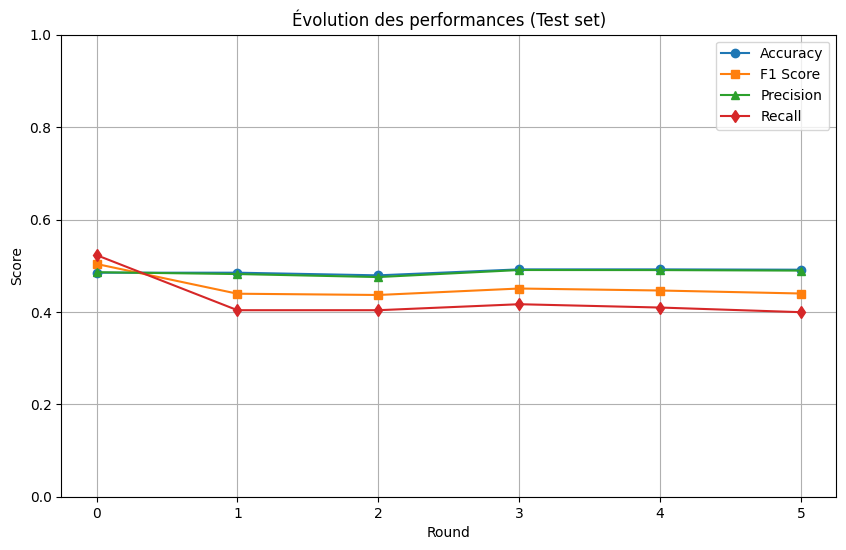

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Charger les métriques
df = pd.read_csv("fl_global_metrics.csv")

# Tracer les courbes de performance
plt.figure(figsize=(10, 6))
plt.plot(df["accuracy"], label="Accuracy", marker="o")
plt.plot(df["f1_score"], label="F1 Score", marker="s")
plt.plot(df["precision"], label="Precision", marker="^")
plt.plot(df["recall"], label="Recall", marker="d")
plt.title("Évolution des performances (Test set)")
plt.xlabel("Round")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.show()


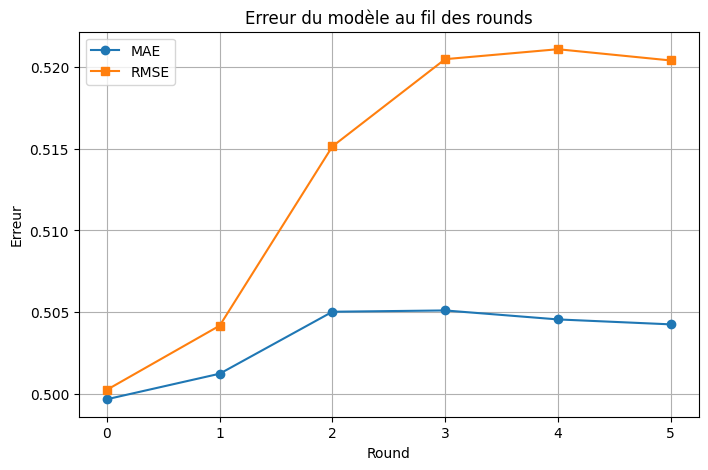

In [7]:
plt.figure(figsize=(8, 5))
plt.plot(df["mae"], label="MAE", marker="o")
plt.plot(df["rmse"], label="RMSE", marker="s")
plt.title("Erreur du modèle au fil des rounds")
plt.xlabel("Round")
plt.ylabel("Erreur")
plt.legend()
plt.grid(True)
plt.show()


🎯 Final Evaluation on Test Set:
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 168ms/step

✅ Test Accuracy: 0.4835
✅ F1 Score: 0.5645
✅ Precision: 0.4880
✅ Recall: 0.6695
✅ MAE: 0.5002
✅ RMSE: 0.5006

🧩 Confusion Matrix:
[[207 489]
 [230 466]]


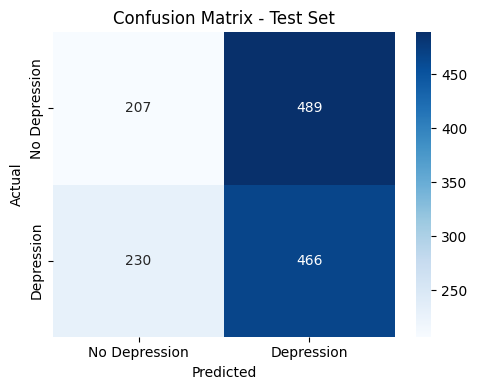

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# --- Final Evaluation on TEST SET ---
final_model = compile_model()
# ⚠️ Replace with last global weights if saved; this is placeholder:
# final_model.set_weights(last_global_weights)

print("\n🎯 Final Evaluation on Test Set:")
y_pred_test = final_model.predict([X_audio_test, X_text_test])
y_pred_labels_test = (y_pred_test > 0.5).astype(int)

# Metrics
acc = accuracy_score(y_test, y_pred_labels_test)
f1 = f1_score(y_test, y_pred_labels_test)
prec = precision_score(y_test, y_pred_labels_test)
rec = recall_score(y_test, y_pred_labels_test)
mae_val = np.mean(np.abs(y_test - y_pred_test))
rmse_val = np.sqrt(np.mean((y_test - y_pred_test) ** 2))
cm = confusion_matrix(y_test, y_pred_labels_test)

# Display results
print(f"\n✅ Test Accuracy: {acc:.4f}")
print(f"✅ F1 Score: {f1:.4f}")
print(f"✅ Precision: {prec:.4f}")
print(f"✅ Recall: {rec:.4f}")
print(f"✅ MAE: {mae_val:.4f}")
print(f"✅ RMSE: {rmse_val:.4f}")
print("\n🧩 Confusion Matrix:")
print(cm)

# Optional: plot confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["No Depression", "Depression"], yticklabels=["No Depression", "Depression"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Test Set")
plt.tight_layout()
plt.show()
